In [24]:
import pandas as pd
import random
from pydataquery import DataQuery
from matplotlib.colors import LinearSegmentedColormap
from xbbg import blp
import numpy as np
import pytz
import time
from datetime import datetime, timedelta
import statsmodels.api as sm
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import re
import scipy.stats as stats
from adjustText import adjust_text
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sympy as sp
import itertools
import warnings
import openpyxl
import subprocess
import dataframe_image as dfi
import time
import pyautogui
import pygetwindow as gw
import pyodbc
import ast
warnings.filterwarnings("ignore")

In [2]:
try:
    df_original = pd.read_parquet("Markit CDS.parquet/")
    
    to_date = datetime.today().date()
    from_date = df_original["close_date"].iloc[-1].date()
    
    from_date_str = from_date.strftime('%m/%d/%Y')
    to_date_str = to_date.strftime('%m/%d/%Y')
    
    conn_str = (
        f'DRIVER={{SQL Server}};'
        f'SERVER=BC-ODS-P1;'
        f'DATABASE=MarkitDB;'
        f'ApplicationIntent=ReadOnly;'
        f'Trusted_Connection=Yes;'
        f'Authentication=ActiveDirectoryIntegrated;'
    )
    
    conn = pyodbc.connect(conn_str)
    
    query1 = f"""
        DECLARE @FromDate DATE = '{from_date_str}';
        DECLARE @ToDate DATE = '{to_date_str}';
        
        SELECT sc.close_date, r.ticker, c.red, c.tier, c.docclause, c.ccy, sc.tenor, sc.spread
        FROM dbo.RedEntities r
        INNER JOIN dbo.MarkitCurves c ON r.red = c.red
        INNER JOIN dbo.MarkitSpreadCurve sc ON c.curve_id = sc.curve_id
        WHERE sc.close_date >= @FromDate AND sc.close_date <= @ToDate;
    """
    
    df_new = pd.read_sql(query1, conn)
    conn.close()

    df_old = df_original[df_original["close_date"]<pd.to_datetime(df_original["close_date"].iloc[-1])]

    df1 = pd.concat([df_old, df_new])
    df1 = df1.drop_duplicates()
    df1.to_parquet("Markit CDS.parquet")
except:
    df1 = pd.read_parquet("Markit CDS.parquet")
    hello = 1

In [3]:
markit_cds = list(set(df1["red"]))
markit_df1 = df1.copy()

res_codes = { "Full Restructuring": "CR14", "Modified Restructuring": "MR14",
          "Modified-Modified Restructurin": "MM14", "No Restructuring": "XR14"}

excel_df = None
all_dq = None
all_temp_cds = None

for rating_col in["IG","HY","EUR_IG","EUR_HY","SNRFIN","SUBFIN","Extras"]:
    dq = pd.read_excel("CDX Members.xlsx", sheet_name=rating_col)
    dq["Restructuring"] = dq["Restructuring"].apply(lambda x: res_codes[x])
    dq = dq[dq["Actual RED Code"].isin(markit_cds)].reset_index(drop=True).copy()
    dq.rename(columns={"Actual RED Code": "red"}, inplace=True)
    
    if not "Family" in dq.columns:
        dq["Family"] = [rating_col]*len(dq)
        
    if not "tier" in dq.columns:
        dq["tier"] = "SNRFOR" if rating_col != "SUBFIN" else "SUBLT2"
    
    dq["ccy"] = dq["Family"].apply(lambda x: "USD" if x in ["IG","HY"] else "EUR")
    dq = dq.drop(["5Y CDS Ticker","ISIN","RED Code","Company Name","Corp Ticker"],axis=1)
    
    all_dq = pd.concat([all_dq, dq]).drop_duplicates(keep="first").reset_index(drop=True).copy()

unique_all_dq = all_dq.drop("Family",axis=1).drop_duplicates().reset_index(drop=True).copy()
unique_all_dq.columns = unique_all_dq.columns.str.replace("Restructuring","docclause")

cds_df = pd.merge(left=df1, right = unique_all_dq, on=["red","docclause","tier","ccy"], how="inner")
cds_df["close_date"] = pd.to_datetime(cds_df["close_date"])
cds_df = cds_df[cds_df["tenor"]!="Spot"]
cds_df["tenor"] = cds_df["tenor"].apply(lambda x: eval(x.replace("y","*1").replace("m","*(1/12)")))

cds_df["ticker_red_tier_ccy_docclause"] = (cds_df["ticker"].astype(str) + "_" + cds_df["red"].astype(str) +\
     "_" + cds_df["tier"].astype(str) + "_" + cds_df["ccy"].astype(str) + "_" + cds_df["docclause"].astype(str))
cds_df = cds_df.drop(["ticker","red","tier","ccy","docclause"],axis=1)

########################### Creating map for family
f = all_dq.drop_duplicates().reset_index(drop=True).copy()
f1 = f["Issuer Equity"].astype(str) + "_" + f["red"].astype(str) + "_" +\
f["tier"].astype(str) + "_" + f["ccy"].astype(str)  + "_" + f["Restructuring"].astype(str)
f2 = f["Family"]
f_dict = dict(zip(f1,f2))

In [4]:
##############################################################################################################

issuers = list(sorted(set(cds_df["ticker_red_tier_ccy_docclause"])))
last_dt = max(cds_df["close_date"])

all_curves = None

try:
    all_curves = pd.read_excel("All CDS Curves.xlsx/") ############## made to fail
    for issuer in issuers:
        df = cds_df[cds_df["ticker_red_tier_ccy_docclause"]==issuer]
        df = pd.pivot_table(df, values="spread", index="close_date", columns ="tenor")
        
        if not last_dt in df.index:
            df.loc[last_dt] = [np.nan] * len(df.columns)
        df = df.sort_index().ffill().copy()
        df[f"{issuer}_curve"] = [np.nan] * len(df)
    
        for idx in df.index:
            curve = df.loc[[idx],:].dropna(axis=1)
            curve = curve.iloc[:,:-1].copy()
            x = list((curve.columns))
            x2 = [item**2 for item in x]
            X = np.column_stack([x, x2])
            Y = list(curve.iloc[0])
    
            if len(X) > 2:
                model = sm.OLS(Y, sm.add_constant(X)).fit()
                df.loc[idx,f"{issuer}_curve"] = str([model.params[0], model.params[1], model.params[2]])
                
                # x_pred = list(np.linspace(min(x), max(x),100))
                # x_pred2 = [item**2 for item in x_pred]
                # X_pred = np.column_stack([x_pred, x_pred2])
                # y_pred = model.predict(sm.add_constant(X_pred))
                # plt.plot(x, Y)
                # plt.plot(x_pred, y_pred)
                # title = f"{issuer} on {str(idx.date())}"
                # plt.title(title)
                # # plt.savefig(f"Curve Plots v2/{title}.png")
                # plt.show()
                # plt.close()
                
            else:
                df.loc[idx,f"{issuer}_curve"] = str([np.nan, np.nan, np.nan])
    
        all_curves = pd.concat([all_curves,df.iloc[:,[-1]]],axis=1)
    all_curves.to_excel("All CDS Curves.xlsx")
except:
    all_curves = pd.read_excel("All CDS Curves.xlsx",index_col=0, parse_dates=True)
    hello=1

all_curves1 = all_curves.copy()
all_curves = all_curves.T.copy()
all_curves.index.name = "ticker_red_tier_ccy_docclause"
all_curves.columns = [f'CDS_{item.date()}' for item in all_curves.columns]
all_curves = all_curves.reset_index(drop=False).copy()
all_temp_cds = all_curves.copy()
all_temp_cds["Temp"] = (all_temp_cds["ticker_red_tier_ccy_docclause"].astype(str).\
    str.split("_", n=1).str[1].str.replace("_curve", "", regex=False))

In [5]:
unique_all_dq["Issuer Equity_red_tier_ccy_docclause"] = (unique_all_dq["Issuer Equity"].astype(str) + "_" + unique_all_dq["red"].astype(str) +\
     "_" + unique_all_dq["tier"].astype(str) + "_" + unique_all_dq["ccy"].astype(str) + "_" + unique_all_dq["docclause"].astype(str))
unique_all_dq = unique_all_dq.drop(["Issuer Equity","red","tier","ccy","docclause"],axis=1)
unique_all_dq["Temp"] = unique_all_dq["Issuer Equity_red_tier_ccy_docclause"].astype(str).str.split("_", n=1).str[1]

df2 = pd.merge(left=unique_all_dq, right=all_temp_cds, on="Temp", how="inner").drop(["Temp","ticker_red_tier_ccy_docclause"], axis=1)

In [6]:
markit_to_bbg_tier_map = {"SNRFOR": "Sr Unsecured", "SUBLT2": "Subordinated"}

l1 = [item.split("_")[0] for item in df2["Issuer Equity_red_tier_ccy_docclause"]]
l2 = [markit_to_bbg_tier_map[item.split("_")[2]] for item in df2["Issuer Equity_red_tier_ccy_docclause"]]
l3 = [item.split("_")[3] for item in df2["Issuer Equity_red_tier_ccy_docclause"]]
l4 = [item.split(" ")[0] for item in df2["Bond Name"]]
bbg_bonds_dict = {}

for i in range(len(l1)):
    bbg_bonds_dict[f"{l1[i]} Equity_{l2[i]}_{l3[i]}"] = l4[i]

In [7]:
# ##########################################################################This Data was copied to All Bonds sheet
# bql_list = []

# fl = [f"""=BQL("filter(bonds(['""",
#       f"""']), payment_rank=='""",
#       f"""' AND crncy=='""",
#       f"""')", "id_isin, id_cusip, name, maturity, amt_outstanding")"""]

# for item, key in bbg_bonds_dict.items():
#     bql_list += [fl[0] + item.split("_")[0] + fl[1] + item.split("_")[1] + fl[2] + item.split("_")[2] + fl[3]]

    
# bql_list = [item.replace("\\", "") for item in bql_list]

# workbook = openpyxl.load_workbook(r"J:\\HY Basis Data.xlsx")
# sheet = workbook.active

# for row in sheet.iter_rows():
#     for cell in row:
#         cell.value = None

# start_col = 1
# for item in bql_list:
#     cell = sheet.cell(row=2, column=start_col)
#     cell.value = item
#     start_col += 6
# workbook.save(r"J:\\HY Basis Data.xlsx")

# file_path = r"J:\\HY Basis Data.xlsx"
# window_title = "HY Basis Data - Excel"

# subprocess.Popen(['start', 'excel', file_path], shell=True)
# time.sleep(5)

# excel_windows = [window for window in gw.getWindowsWithTitle('Excel')]

# for window in excel_windows:
#     if window_title in window.title:
#         # time.sleep(0.5)
#         window.activate()
#         break

# time.sleep(45)
# pyautogui.hotkey('ctrl', 's')
# time.sleep(1)
# # pyautogui.hotkey('alt', 'f4')

# time.sleep(1.5)

In [8]:
bonds_map = []
markit_to_bbg_tier_map_reverse = dict(zip(list(markit_to_bbg_tier_map.values()), list(markit_to_bbg_tier_map.keys())))

for i in range(len(l1)):
    bonds_map += [f"{l1[i]}_{markit_to_bbg_tier_map_reverse[l2[i]]}_{l3[i]}"]

In [9]:
df = pd.read_excel("All Bonds.xlsx", sheet_name="All Bonds")
l5 = [item.split("_")[0].replace(" Equity","") + "_" + markit_to_bbg_tier_map_reverse[item.split("_")[1]] +\
      "_" + item.split("_")[2] for item in list(bbg_bonds_dict.keys())]
l6 = list(bbg_bonds_dict.values())

all_df = None

for i in range(len(df.columns))[::6]:
    x = df.iloc[:,i:i+6].dropna().copy()
    # display(l6[int(i/6)].split("_")[0])
    # display(df.iloc[:,i:i+6].dropna(how="all"))
    if len(x) > 0:
        x.columns = ['ID','ISIN', "CUSIP", 'Name', 'Maturity','Amt']
        x["Issuer Equity_tier_ccy"] = [l5[int(i/6)]] * len(x)
        x["Bond Name"] = [l6[int(i/6)]] * len(x)
        x["Check Col"] = x.apply(lambda row: row["Name"].split(" ")[0]==row["Bond Name"],axis=1)
        x = x[x["Check Col"]].drop(["Check Col","Bond Name"],axis=1)
        all_df = pd.concat([all_df, x])

all_df['Time'] = round(((pd.to_datetime(all_df['Maturity'])-datetime.now()).dt.days/365),2)
all_df = all_df[all_df["Time"]>=0]
all_df = all_df[(all_df['Time']>=4) & (all_df['Time']<=10)]
all_df = all_df[all_df['Amt']>=300*10**6]
all_df = all_df.reset_index(drop=True)
excel_df = pd.concat([excel_df, all_df])
all_df = excel_df.copy()

all_df = all_df.drop_duplicates(keep="first").reset_index(drop=True).copy()

########################################################################################### 144A and REGS

blist = [f'/isin/{item}@BGN' for item in list(all_df["ISIN"])]
blist = blp.bdp(tickers=blist, flds=["144A_FLAG","IS_REG_S"])
blist.to_parquet("144A.parquet")
blist = pd.read_parquet("144A.parquet")
blist.index = [item.rsplit("/",1)[1].split("@")[0] for item in blist.index]

blist.columns = ["144A","REGS"]
blist.index.name = "ISIN"
blist = blist.reset_index()
blist["REGS_144A"] = blist.apply(lambda row: f'{row["REGS"]}_{row["144A"]}',axis=1)
order = ["N_N", "Y_N", "Y_Y", "N_Y"]

all_df = pd.merge(left=all_df, right=blist, on="ISIN", how="outer")
all_df = all_df[[item for item in all_df.columns if not item in ["144A","REGS"]]]

all_df["REGS_144A"] = pd.Categorical(all_df["REGS_144A"], categories=order, ordered=True)
all_df = all_df.sort_values(by="REGS_144A")
all_df = all_df[~all_df["Name"].duplicated(keep='first')].drop(["REGS_144A","Time"],axis=1).reset_index(drop=True).copy()

In [10]:
t = [f"/isin/{item}@BGN" for item in list(all_df["ISIN"])]
# bbg = blp.bdh(tickers=t, flds="BLOOMBERG_MID_G_SPREAD", start_date=datetime.now()-timedelta(days=365*5))
# bbg.to_parquet("Test1.parquet")
bbg = pd.read_parquet("Test1.parquet")

bbg1 = bbg.copy()
new = []
for item in bbg1.columns:
    new += ["BBG_" + item[0].replace("/isin/","").replace("@BGN","")]
bbg1.columns = new
bbg1.index = pd.to_datetime(bbg1.index)

############################################################ choose bbg or dq sprds

bbg1.columns = [item.split("_")[1] for item in bbg1.columns]
bbg1.index = [f"Sprd_{str(item.date())}" for item in bbg1.index]
bbg1 = bbg1.T.copy()
bbg1.index.name = "ISIN"
bbg1 = bbg1.reset_index(drop=False).copy()

In [11]:
df2a = df2.drop(["Primary ISIN","Bond Name"],axis=1).copy()
df2a["Issuer Equity_tier_ccy"] = [item.split("_")[0] + "_" + item.split("_")[2] +\
               "_" + item.split("_")[3] for item in df2a["Issuer Equity_red_tier_ccy_docclause"]]
# df2a = df2a.replace(np.nan,"[np.nan, np.nan, np.nan]")
df3 = pd.merge(left=all_df, right=df2a, on="Issuer Equity_tier_ccy",\
               how="inner").drop(["ID","Amt","Issuer Equity_tier_ccy"],axis=1).copy()

for dt in pd.to_datetime(bbg.index):
    df3[f'Mat_Time_{dt.date()}'] = [((pd.to_datetime(item) - dt).days/365) for item in df3["Maturity"]]

df4A = df3.copy()
dt_list = [item.replace("CDS_","") for item in df4A.columns if item.startswith("CDS_")]

# for dt in dt_list:
#     if f"Mat_Time_{dt}" in df4A.columns and f"CDS_{dt}" in df4A.columns:
#         df4A[f'Mat_Matched_CDS_{dt}'] = df4A[f'CDS_{dt}'].apply(lambda x: ast.\
#             literal_eval(x)[0] if isinstance(x,str) else np.nan) +\
#         df4A[f'Mat_Time_{dt}'].apply(lambda x: x) *\
#         df4A[f'CDS_{dt}'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x,str) else np.nan) +\
#         df4A[f'Mat_Time_{dt}'].apply(lambda x: x**2) *\
#         df4A[f'CDS_{dt}'].apply(lambda x: ast.literal_eval(x)[2] if isinstance(x,str) else np.nan)

def safe_literal_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else [np.nan, np.nan, np.nan]
    except (ValueError, SyntaxError):
        return [np.nan, np.nan, np.nan]

for dt in dt_list:
    if f"Mat_Time_{dt}" in df4A.columns and f"CDS_{dt}" in df4A.columns:
        cds_values = df4A[f'CDS_{dt}'].apply(safe_literal_eval)
        mat_time = df4A[f'Mat_Time_{dt}']

        df4A[f'Mat_Matched_CDS_{dt}'] = (
            cds_values.apply(lambda x: x[0]) +
            mat_time * cds_values.apply(lambda x: x[1]) +
            mat_time**2 * cds_values.apply(lambda x: x[2]))

df4 = df4A[["ISIN","CUSIP","Name","Maturity","Issuer Equity_red_tier_ccy_docclause"] +\
    [col for col in df4A.columns if col.startswith("Mat_Matched_CDS")]].copy()

In [12]:
#################################################### Duration Data

dq_bonds = ['US50077LBF22','US49456BAG68','US49456BAR24','US49456BAV36','US49456BAX91','US500255AX28','US50077LAL09','US50077LAV80','US50077LBN55','US526057CY87','US530715AJ01','US501044DV05','US48666KAY55','US48666KAZ21','US48666KBA60','US620076BT59','US626717AP72','US63938CAN83','US63938CAP32','US63938CAQ15','US651229BD74','US549271AF19','US55262CAJ99','US552676AT59','US552676AU23','US552953CJ87','US552953CK50','US55342UAM62','US55616XAM92','US58013MFQ24','US382550BJ95','US382550BK68','US382550BR12','US382550BS94','US404119CA57','US404119CC14','US404119CK30','US404119CQ00','US404119CT49','US337932AL12','US337932AP26','US345370CA64','US345370CX67','US345370DA55','US345370DB39','US35671DBJ37','US35671DCD57','US35671DCF06','US35671DCH61','US36186CBY84','US36962GXZ26','US370334CL64','US370334CT90','US37045VAH33','US37045VAY65','US37045VAZ31','US404119DB22','US404121AK12','US458140BR09','US651229BE57','US44107TBC99','US40434LAN55','US42307TAG31','US432833AF84','US437076CB65','US44106MAY84','US44106MBB72','US44107TAY29','US44107TAZ93','US651229BF23','US89352HBA68','US893830AF64','US902494AZ66','US911363AM11','US911365BL76','US911365BP80','US91324PEJ75','US911365BN33','US88947EAU47','US85172FAR01','US87264ABF12','US87264ABT16','US87264ABW45','US87264ABX28','US87264ACB98','US87264ACQ67','US87264ACV52','US87264ADT97','US87901JAH86','US88033GAV23','US88167AAR23','US88167AAS06','US88167AAT88','US962166BR41','US963320AY28','US963320AZ92','US963320BA33','US963320BC98','US963320BD71','US963320BE54','US969457BB59','US969457BM15','US969457BZ28','US969457CJ76','US988498AN16','US988498AP63','US988498AR20','XS0161100515','US931142FC22','US92343VEU44','US92343VFX73','US92343VGN82','US92343VGY48','US92343VGZ13','US925524AH30','US925524AV24','US92556HAB33','US92556HAD98','US680665AK27','US682691AA80','US682691AE03','US682691AF77','US682691AG50','US682691AJ99','US682691AK62','US682691AL46','US68389XBV64','US68389XCE31','US68389XCH61','US68389XCJ28','US69047QAC69','US674599EL59','US674599EK76','US65339KCU25','US65339KDJ60','US65339KDK34','US65339KDL17',
'US674599DD43','US674599DE26','US674599EA94','US674599ED34','US674599EF81','US698900AG20','US75513ECR09','US78355HLC15','US78442FAZ18','US81761LAE20','US828807DT11','US716973AD41','US716973AE24','US717081EW90','US745867AM30','US745867AP60','US745867AT82','US74834LBC37','US30212PBH73','US1248EPCN14','US012873AK13','US012873AH83','US11135FAS02','US11135FBD24','US136385AE19','US134429BJ73','US126650DJ69','US00206RMM15','US126650DU15','US126650ED80','US031162DQ06','US026874DC84','US02406PBB58','US023551AM66','US023551AJ38','US097023CN34','US097023CP81','US097023CY98','US097023DC69','US097023DR39','US097023CJ22','US097023DS12','US023135AP19','US097023AU94','US023551AF16','US058498AW66','US058498AX40','US058498BA38','US07556QBT13','US08652BAB53','US071813BY49','US254709AS70','US244199BJ37','US247361ZT81','US251799AA02','US25179MBF95','US25179SAD27','US247361A329','US23331ABT51','US29273VAU44','US29273VBA70','US29278NAQ60','US30161NAX93','US30212PAR64','US29273VAT70','US29273RBE80','US28368EAD85','US28368EAE68','US292480AM22','US29273VAQ32','US292505AD65','US20030NEE76','US20030NDG34','US20030NBH35','US15089QAZ72','US15089QBA13','US15089QAY08','US00206RCP55','US15089QAP90','US00130HCG83','US15089QAX25','US205887AX04','XS2774392638','XS2655993033','XS3037720227','XS3023963534','XS3126635039','XS3106096178','XS3105513769','XS3091660194','XS2872799734','XS2870878456','XS2864439158','XS2811097075','XS2802883731','XS2826718087','XS2929387996','XS2922654418','XS2914769299','XS2904791774','XS2385393587','XS2116386132','XS2432162654','XS2247549731','XS2189766970','XS2300293003','XS2290544068','XS2056491587','XS2488809612','XS2010039894','FR001400WJR8','FR001400PAJ8','DE000A383HC1','CH0494734418','CH0591979627','DE000A4DFLQ6','US46284VAQ41','US501797AW48','US513272AD65','US513272AE49','US53219LAX73','US46284VAN10','US55617LAR33','US55617LAS16','US62482BAB80','US46284VAL53','US44332PAJ03','US46284VAF85','US37441QAA94','US428040DB25','US431318AV64','US431318AY04','US431318AZ78','US431318BC74','US431318BE31','US431318BG88','US432833AL52','US432833AN19','US432833AQ40','US432833AR23','US432833AS06','US44332PAG63','US62886HBP55','US46284VAJ08','US62886HBR12','US629377CS98','US629377CR16','US780153BV38','US780153BW11','US81211KAK60','US812127AB45','US812127AC28','US82967NBG25','US82967NBM92','US853496AG21','US853496AH04','US893830BZ10','US911365BR47','US92840VAP76','US92840VAR33','US947075AU14','US988498AL59','US780153BU54','US75606DAQ43','US737446AV69','US629377CW01','US629377CX83','US62957HAP01','US62957HAQ83','US63861CAF68','US64110LAU08','US64110LAV80','US677347CH71','US680665AN65','US68622FAB76','US68622TAB70','US737446AP91','US737446AQ74','US737446AR57','US737446AX26','US364760AQ18','US11135FBF71','US11135FBH38','US11135FBK66''US11135FBL40','US11135FBT75','US1248EPCD32','US1248EPCE15','US1248EPCK74','US1248EPCL57','US1248EPCP61','US1248EPCQ45''US1248EPCS01','US1248EPCT83','US126307BA42','US126307BB25','US103304BV23','US126307BD80','US097751CD18','US097751CB51','US00130HCC79','US01883LAD55','US01883LAH69','US03743QAQ10','US04433LAA08','US05368VAA44','US05368VAB27','US053773BH95','US053773BJ51','US053773BK25','US071734AJ60','US071734AL17','US097751AL51','US097751CA78','US097751CC35','US126307BF39','US126307BH94','US126307BK24','US224044CS42','US226373AT56','US23918KAS78','US23918KAT51','US23918KAW80','US23918KAY47','US185899AS01','US185899AR28','US12769GAA85','US12769GAD25','US131347CQ78','US143658BX94','US143658BY77','US364760AP35','US143658BZ43','US17888HAB96','US17888HAC79','US17888HAD52','US185899AL57','US185899AN14','US185899AP61','US185899AQ45','US143658CA82']

dq_bonds = list(df4["ISIN"])
all_labels = dict(zip(df4["ISIN"],[f"DB(CREDIT,HY,BOND,{item},MDUR)" for item in df4["CUSIP"]]))

labels = {}
for item in dq_bonds:
    labels[f"{item}_Dur"] = all_labels[item]

try:
    df1 = pd.read_excel("DQ HY Duration Data.xlsx/",index_col=0, parse_dates=True)
    dq = DataQuery(
        client_id='jbAIMF2Tkp0JO3sc',
        client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
        calendar = 'CAL_USBANK',
    )
    
    job = dq.create_job(expressions = list(labels.values()))
    dq.start_date = str((datetime.now()-timedelta(days=5*365)).date())
    job.execute(alert_long_requests='ignore')
    df = job.to_pivot_table()
    df = df.T
    df.index.name = 'Date'
    df.index = pd.to_datetime(df.index, format='%Y%m%d').date
    df.columns.name = None
    
    df1 = pd.DataFrame()
    for key in labels:
        df1[key] = df[labels[key]]
    
    df1 = df1[list(labels.keys())].copy()
    clear_output(wait=False)
    df1.dropna(axis=1, how='all', inplace=True)
    df1.to_excel("DQ HY Duration Data.xlsx")
except:
    df1 = pd.read_excel("DQ HY Duration Data.xlsx",index_col=0, parse_dates=True)

In [13]:
df1a = df1.copy()
df1a = df1a.T
df1a.index = df1a.index.str.replace("_Dur","")
df1a.columns = ["Dur_" + str(item.date()) for item in df1a.columns]
df1a.index.name="ISIN"
df1a = df1a.reset_index()

df4B = pd.merge(left=df4, right=df1a, on="ISIN", how="outer")

####################################################################

t = [f"/isin/{item}@BGN" for item in list(all_df["ISIN"])]
# px = blp.bdh(tickers=t, flds="PX_LAST", start_date=datetime.now()-timedelta(days=365*5))
# px.to_parquet("Test2.parquet")
px = pd.read_parquet("Test2.parquet")

new = []
for item in px.columns:
    new += [item[0].replace("/isin/","").replace("@BGN","")]
px.columns = new
px = px.T
px.columns = ["Price_" + str(item) for item in px.columns]
px.index.name= "ISIN"
px = px.reset_index()

####################################################
df5a = pd.merge(left=df4B, right=bbg1, on="ISIN", how="inner")
last_update = max(dt_list)
for dt in dt_list:
    try:
        df5a[f"Basis_{dt}"] = df5a[f"Mat_Matched_CDS_{dt}"] - df5a[f"Sprd_{dt}"]
    except:
        hello = 1

df5a = pd.merge(left=df5a, right=px, on="ISIN", how="inner")

In [14]:
df5 = df5a.copy()
df5 = df5[["ISIN","CUSIP","Name","Maturity","Issuer Equity_red_tier_ccy_docclause"] +\
    [col for col in df5.columns if last_update in col or "Basis_" in col]].copy()

####################################### Zscore and 1Y High/Low Calc

dfz = df5[["ISIN"] + [item for item in df5.columns if "Basis" in item]]
dfz = dfz.set_index("ISIN").T
dfz.index = [pd.to_datetime(item.split("_")[1]).date() for item in dfz.index]
dfz = dfz.sort_index()

all_z_df = None
for period in [3*22, 6*22, 12*22]:
    x = ((dfz-dfz.rolling(period, min_periods = int(0.6*period)).mean())/dfz.rolling(period,\
                  min_periods = int(0.6*period)).std()).iloc[[-1],:].copy()
    x.index = [f'ZScore_{int(period/22)}M']
    all_z_df = pd.concat([all_z_df , x])

max_1y = pd.DataFrame(dfz.iloc[-12*22:,:].max()).T
max_1y.index = [f'Basis 1Y High']
min_1y = pd.DataFrame(dfz.iloc[-12*22:,:].min()).T
min_1y.index = [f'Basis 1Y Low']

all_z_df = pd.concat([all_z_df , max_1y, min_1y])
all_z_df = all_z_df.T
all_z_df = all_z_df.reset_index()

df6 = pd.merge(left=df5.drop([col for col in df5.columns if col.\
    startswith("Basis_") and not last_update in col],axis=1),\
               right=all_z_df, on="ISIN", how="inner").drop(["CUSIP","Maturity"],axis=1).copy()

In [15]:
df7 = df6.drop(f"Dur_{last_update}",axis=1).copy()
df7["Family"] = df7["Issuer Equity_red_tier_ccy_docclause"].apply(lambda x: f_dict[x])
df7["CDS RED Code"] =  df7["Issuer Equity_red_tier_ccy_docclause"].apply(lambda x: x.split("_")[1])
df7.columns = df7.columns.str.replace(f"_{last_update}","").str.replace("Mat_Matched_CDS","Mat. Matched CDS")
df7["First Sort"] = df7["Name"].apply(lambda x: x.split(" ")[0])
df7["Second Sort"] = df7["Name"].apply(lambda x: x.rsplit("/")[-1])

df7 = df7.sort_values(by=["First Sort","Second Sort"],ascending=[True, True])
df7 = df7.drop(["ISIN","Issuer Equity_red_tier_ccy_docclause","First Sort","Second Sort"], axis=1).set_index("Name").copy()

df7 = df7[["Family","CDS RED Code","Price","Sprd","Mat. Matched CDS","Basis","Basis 1Y Low","Basis 1Y High",\
           "ZScore_3M","ZScore_6M","ZScore_12M"]].copy()
df7 = round(df7,2)

In [22]:

issuers_list

['ACAFP',
 'ASSGEN',
 'BACR',
 'BACRED',
 'BBVASM',
 'BNP',
 'CMZB',
 'DANBNK',
 'DB',
 'HSBC',
 'INTNED',
 'ISPIM',
 'LLOYDS',
 'RABOBK',
 'SHBASS',
 'SOCGEN',
 'STANLN',
 'SWEDA',
 'UCGIM']

In [38]:
for rating_col in ["IG","HY","EUR_IG","EUR_HY","SNRFIN","SUBFIN"]:
    df1 = df7[df7["Family"]==rating_col].drop("Family",axis=1)
    df1["Issuer"] = [item.split(" ")[0] for item in df1.index]
    
    num_issuers = len(set([item.split(" ")[0] for item in df1.index]))
    
    issuers_per_table = 4
    # issuers_list = list(sorted(set([item.split(" ")[0] for item in df1.index])))
    issuers_list = list(sorted(set(df1["Issuer"])))
    
    for i in range(int(num_issuers/issuers_per_table)+1):
        globals()[f'df_{i}'] = df1[df1["Issuer"].isin(issuers_list[issuers_per_table*i:issuers_per_table*i+issuers_per_table])].copy()
    
    modified_dfs = []
    
    for i in range(int(num_issuers / issuers_per_table) + 1):
        df = globals()[f'df_{i}'].reset_index().copy()
        new_df = pd.DataFrame(columns=df.columns)
        
        for issuer in df['Issuer'].unique():
            issuer_rows = df[df['Issuer'] == issuer]
            new_df = pd.concat([new_df, issuer_rows], ignore_index=True)
            empty_row = pd.Series([''] * len(df.columns), index=df.columns)
            new_df = pd.concat([new_df, pd.DataFrame([empty_row])], ignore_index=True)
        globals()[f'df_{i}'] = new_df.set_index(new_df.columns[0]).drop("Issuer",axis=1).copy()
    
    def color_negative_red_positive_green_basis(col: pd.Series):
        if col.empty:
            return ['' for _ in col]
        float_col = col[col.apply(lambda x: isinstance(x, float))]
        min_val, max_val = float_col.min(), float_col.max()
        def value_to_color(val):
            if not isinstance(val, float):
                return ''
            if val < 0 and min_val < 0:
                frac = val/ min_val
                frac = max(min(frac,1),0)
                r = int(255 - (255 - 87) * frac)
                g = int(255 - (255 - 187) * frac)
                b = int(255 - (255 - 138) * frac)
                a = 0.75
                return f'background-color: rgb({r},{g},{b},{a})'
            elif val > 0 and max_val > 0:
                frac = val/ max_val
                frac = max(min(frac,1),0)
                r = int(255 - (255 - 230) * frac)
                g = int(255 - (255 - 135) * frac)
                b = int(255 - (255 - 115) * frac)
                a = 0.75
                return f'background-color: rgb({r},{g},{b},{a})'
            return ''
        return [value_to_color(v) for v in col]
                
    
    def add_vertical_lines(df):
        styles = pd.DataFrame('', index=df.index, columns=df.columns)
        for i in range(1, len(df.columns), 2):
            styles.iloc[:, i] = 'border-right: 8px solid black;'
        return styles
        
    def style_rich_cheap_basis(df):
        styled_df = df.style.apply(color_negative_red_positive_green_basis, subset=df.columns[-3:], axis=0)
        styled_df = styled_df.format(precision=2)
        styled_df = styled_df.format(precision=0, subset=df.columns[2:7])
        styled_df = styled_df.format(precision=1, subset=df.columns[-3:])
        styled_df = styled_df.set_properties(**{'text-align': 'center'})
        styled_df = styled_df.applymap(lambda val: 'font-weight: bold', subset=pd.IndexSlice[:, df.columns[4]])
        return styled_df
        
    for i in range(int(num_issuers / issuers_per_table) + 1):
        df = globals()[f'df_{i}'].copy()
        index_counts = {}
        new_index = []
        
        for idx in df.index:
            if idx in index_counts:
                index_counts[idx] += 1
                # new_index.append(f"{idx}_{index_counts[idx]}")
                new_index.append(f"{idx}{'_' * index_counts[idx]}{pd.to_datetime(last_update).strftime("%d-%b")}")
    
            else:
                count = df.index.tolist().count(idx)
                if count > 1:
                    index_counts[idx] = 1
                    new_index.append(f"{idx}_{pd.to_datetime(last_update).strftime("%d-%b")}")
                else:
                    new_index.append(idx)
        df.index = new_index
        df.index.name = f'{pd.to_datetime(last_update).strftime("%d-%b")}'
        globals()[f'display_df_{i}'] = style_rich_cheap_basis(df.iloc[:-1,:])
        globals()[f'display_df_{i}'] = globals()[f'display_df_{i}'].set_table_styles(
            [
                {'selector': 'tr', 'props': [('width', '8px')]},
                {'selector': 'th, td', 'props': [('line-height', '8px')]}
            ],)
    
        dfi.export(globals()[f'display_df_{i}'] , f'Plots/{rating_col}/{rating_col}_{i}.png', table_conversion='chrome', dpi=100)
    
    import os
    import win32com.client
    import glob
    import pandas as pd
    import dataframe_image as dfi
    from io import BytesIO
    import tempfile
    
    html_body = "<html><body>"
    
    outlook = win32com.client.Dispatch("Outlook.Application")
    mail = outlook.CreateItem(0)
    
    folder_path = f'J:\\53A. HY Bonds Basis Email\\Plots\\{rating_col}'
    png_files = glob.glob(os.path.join(folder_path, '*.png'))
    png_files = [item for item in png_files if f"{rating_col}_" in item]
    png_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].rsplit("_")[-1]))
    
    for png_file in png_files:
        raw_name = os.path.splitext(os.path.basename(png_file))[0]
        image_cid = raw_name.replace(" ", "_")
        attachment = mail.Attachments.Add(Source=png_file)
        attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", image_cid)
        html_body += f'<img src="cid:{image_cid}"><br><br><br>'
    
    html_body += '</body></html>'
    
    mail.HTMLBody = html_body
    mail.Subject = f'{rating_col.replace("_"," ")} Basis (auto)'
    mail.CC = 'vasu.sharma@iiicm.com'
    mail.To = 'spyros.michas@iiicm.com'
    mail.Send()
    
print("Sent")


Sent


In [35]:
df5[df5["ISIN"]=="US04433LAA08"]

,ISIN,CUSIP,Name,Maturity,Issuer Equity_red_tier_ccy_docclause,Mat_Matched_CDS_2025-08-28,Dur_2025-08-28,Sprd_2025-08-28,Basis_2020-08-31,Basis_2020-09-01,...,Basis_2025-08-18,Basis_2025-08-19,Basis_2025-08-20,Basis_2025-08-21,Basis_2025-08-22,Basis_2025-08-25,Basis_2025-08-26,Basis_2025-08-27,Basis_2025-08-28,Price_2025-08-28
266,US04433LAA08,04433LAA0,ASH 3 ⅜ 09/01/31,2031-09-01,ASH US_0E876I_SNRFOR_USD_XR14,102.097854,5.199914,172.152,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-70.054146,89.127


In [37]:
cds_df[cds_df["Issuer Equity"]=="ASH US"]

,close_date,tenor,spread,Primary ISIN,Issuer Equity,Bond Name,ticker_red_tier_ccy_docclause
4028,2020-08-19,10.00,93.8654,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14
4029,2020-08-19,15.00,99.8405,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14
4030,2020-08-19,1.00,15.4625,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14
4031,2020-08-19,20.00,102.8156,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14
4032,2020-08-19,2.00,23.5010,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14
...,...,...,...,...,...,...,...
3193875,2023-01-18,4.00,86.0586,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14
3193876,2023-01-18,5.00,101.0787,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14
3193877,2023-01-18,0.50,24.4099,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14
3193878,2023-01-18,7.00,117.3262,US04433LAA08,ASH US,ASH 3 3/8 09/01/31,ASHLLLC_0E876I_SNRFOR_USD_XR14


In [43]:
# dfx = pd.read_parquet("Markit CDS.parquet")
x = dfx[(dfx["red"]=="0E876I") & (dfx["tier"]=="SNRFOR") & (dfx["docclause"]=="XR14") &\
    (dfx["ccy"]=="USD") & (dfx["tenor"]=="5y")].copy()

Text(0.5, 1.0, 'ASHLAND')

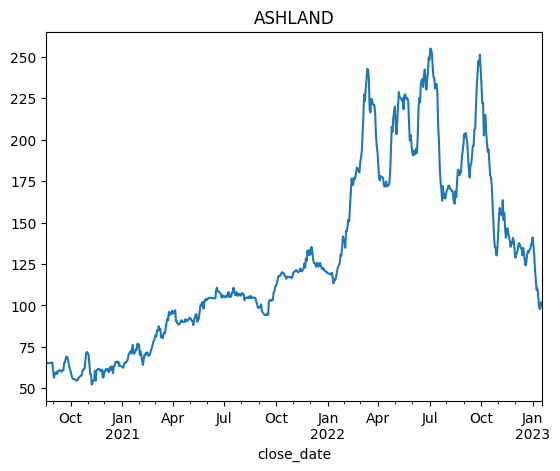

In [48]:
y = x.copy()
y["close_date"] = pd.to_datetime(y["close_date"])
y = y.set_index("close_date")
y["spread"].plot()
plt.title("ASHLAND")
# y